In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
import pickle
import baltic as bt
import json

In [6]:
fulltree_file = '../titer_model/full_tree_model_output/dengue_all_tree.json'
interserotypetree_file = '../titer_model/interserotype_model_output/dengue_all_tree.json'
allEffects_performance_file = '../titer_model/full_tree_model_output/titer_model_performance.csv'
interserotypeEffects_performance_file = '../titer_model/interserotype_model_output/titer_model_performance.csv'

In [7]:
colors = pickle.load(open('./colors.p', 'rb'))

In [8]:
allEffects_perf = pd.read_csv(allEffects_performance_file, index_col=None)
interserotypeEffects_perf = pd.read_csv(interserotypeEffects_performance_file, index_col=None)

allEffects_perf['model'] = 'full tree'
interserotypeEffects_perf['model'] = 'interserotype'

performance = pd.concat([allEffects_perf, interserotypeEffects_perf])
performance.rename(columns={"r_squared": r'Pearson $R^2$', 'rms_error': 'Root mean\nsquared error'}, inplace=True)
performance = performance.melt(id_vars=['model'], value_vars=[r'Pearson $R^2$', 'Root mean\nsquared error'], 
                          value_name='value', var_name='metric')

In [9]:
fulltree = bt.loadJSON(fulltree_file, {'name': 'strain', 'height': 'div'})
interserotypetree = bt.loadJSON(interserotypetree_file, {'name': 'strain', 'height': 'div'})


Tree height: 0.352840
Tree length: 2.074358
annotations present

Numbers of objects in tree: 92 (45 nodes and 47 leaves)


Tree height: 0.352840
Tree length: 2.074358
annotations present

Numbers of objects in tree: 92 (45 nodes and 47 leaves)



In [10]:
def plot_tree(ll, ax, color):
    sns.set(style='white',font_scale=1.2)

    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if 'dTiter' in k.traits and k.traits['dTiter'] > 0.05:
            c = color
            branchWidth = 2
        else:
            c = 'gray'
            branchWidth = 1

        if isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.set_yticks([])
    ax.set_xticks([round(x, 2) for x in np.linspace(0, ll.treeHeight, 5)])
    ax.set_ylim(-5,ll.ySpan+7)
    ax.set_xlabel('Substitutions per site')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
def plot_performance(performance, ax):
    sns.set(style='whitegrid',font_scale=1.2)
    sns.boxplot(x='metric', y='value', hue='model', data=performance, hue_order=['interserotype', 'full tree'], 
                palette=[colors['interserotype_effects'], colors['all_effects']], saturation=0.8, notch=True)
#     sns.swarmplot(x='metric', y='value', hue='model', data=performance, hue_order=['interserotype', 'full tree'], 
#                   palette=[colors['interserotype_effects'], colors['all_effects']], dodge=True, alpha=0.8)
    ax.get_legend().remove()    
    ax.set_xlabel('')
    ax.set_ylabel('')

                                           value
model         metric                            
full tree     Pearson $R^2$             0.721162
              Root mean\nsquared error  0.841767
interserotype Pearson $R^2$             0.705941
              Root mean\nsquared error  0.866925


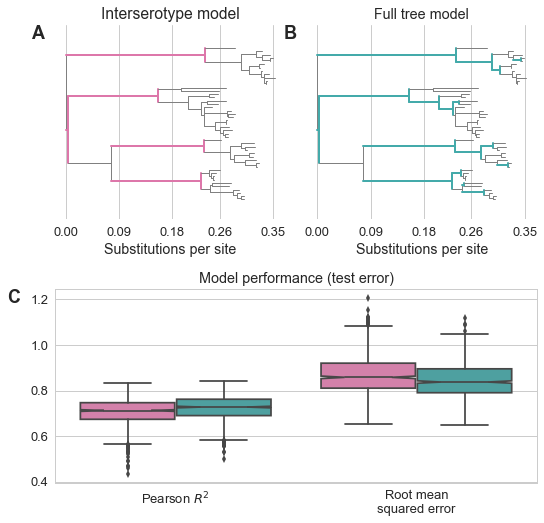

In [11]:
def add_subfigure_label(ax, label, x=-0.1, y=1.0):
    ax.text(x, y, label, va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=ax.transAxes)

plt.figure(figsize=(7.5,7.5))
sns.set(font_scale=1.3, style='whitegrid')
gs = gridspec.GridSpec(2,2)
interserotype_example_ax = plt.subplot(gs[0, 0])
full_tree_example_ax = plt.subplot(gs[0, 1])
performance_ax = plt.subplot(gs[1,:])

interserotype_example_ax.set_title('Interserotype model')
plot_tree(interserotypetree, ax=interserotype_example_ax, color=colors['interserotype_effects'])

full_tree_example_ax.set_title('Full tree model')
plot_tree(fulltree, ax=full_tree_example_ax, color=colors['all_effects'])

performance_ax.set_title('Model performance (test error)')
plot_performance(performance, ax=performance_ax)

add_subfigure_label(interserotype_example_ax, 'A')
add_subfigure_label(full_tree_example_ax, 'B')
add_subfigure_label(performance_ax, 'C')

plt.tight_layout()
# plt.savefig('./png/titer_model_performance.png', dpi=300, bbox_inches='tight')
avg_performance = performance.groupby(['model', 'metric']).agg('mean')
print avg_performance